In [1]:
# ==========================================================
# 1. Research Question & Environment Setup
# ==========================================================
# Purpose:
#   Define the analytical question for Highmark Health:
#   "Can machine learning detect anomalous claim patterns
#   that may indicate fraud, waste, or abuse (FWA)?"
#
#   This notebook explores claim cost, frequency, and provider behavior
#   using unsupervised anomaly detection techniques.
# ==========================================================

import sys
import platform
import pandas as pd
import numpy as np
import matplotlib
import sklearn

# --- Environment Info --------------------------------------------------------
print(f"Python version: {platform.python_version()}")
print(f"Pandas: {pd.__version__}")
print(f"NumPy: {np.__version__}")
print(f"Matplotlib: {matplotlib.__version__}")
print(f"Scikit-learn: {sklearn.__version__}")
print("\n✅ Environment check complete.")


Python version: 3.11.14
Pandas: 2.3.3
NumPy: 2.3.4
Matplotlib: 3.10.7
Scikit-learn: 1.7.2

✅ Environment check complete.


In [2]:
# ==========================================================
# 2. Data Creation & Loading
# ==========================================================
# Purpose:
#   - Create a synthetic healthcare claims dataset for FWA detection.
#   - Each record represents a provider claim with:
#       claim_id, provider_id, member_id, claim_cost,
#       procedure_code, diagnosis_score, and claim_frequency.
#   - Some records will include intentionally anomalous values.
# ==========================================================

import os
import pandas as pd
import numpy as np

# --- Paths -------------------------------------------------------------------
os.makedirs("../data/raw", exist_ok=True)
data_path = "../data/raw/synthetic_claims.csv"

# --- Generate synthetic claims data -----------------------------------------
np.random.seed(42)

n = 3000
providers = [f"P{i:03d}" for i in range(1, 61)]
members = [f"M{i:05d}" for i in range(1, 2001)]
procedure_codes = [f"PROC{i:03d}" for i in range(1, 21)]

df = pd.DataFrame({
    "claim_id": [f"C{i:06d}" for i in range(1, n+1)],
    "provider_id": np.random.choice(providers, n),
    "member_id": np.random.choice(members, n),
    "procedure_code": np.random.choice(procedure_codes, n),
    "claim_cost": np.random.normal(1200, 300, n),
    "diagnosis_score": np.random.normal(50, 10, n),
    "claim_frequency": np.random.poisson(2, n)
})

# --- Introduce anomalies -----------------------------------------------------
anomaly_indices = np.random.choice(df.index, size=40, replace=False)
df.loc[anomaly_indices, "claim_cost"] *= np.random.uniform(3, 10, len(anomaly_indices))
df.loc[anomaly_indices, "diagnosis_score"] += np.random.uniform(20, 40, len(anomaly_indices))

# --- Save and preview --------------------------------------------------------
df.to_csv(data_path, index=False)
print(f"✅ Synthetic dataset created → {data_path}")
print("\nPreview:")
display(df.head())


✅ Synthetic dataset created → ../data/raw/synthetic_claims.csv

Preview:


,claim_id,provider_id,member_id,procedure_code,claim_cost,diagnosis_score,claim_frequency
0,C000001,P039,M01915,PROC010,1278.620043,57.820274,4
1,C000002,P052,M01094,PROC017,615.131485,40.883827,1
2,C000003,P029,M00425,PROC009,1094.745171,49.800816,2
3,C000004,P015,M00999,PROC006,534.495672,47.521199,2
4,C000005,P043,M00708,PROC011,1610.910332,45.716817,2


Summary Statistics:


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
claim_id,3000,3000,C000001,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
provider_id,3000,60,P026,68,NaN,NaN,NaN,NaN,NaN,NaN,NaN
member_id,3000,1532,M00881,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
procedure_code,3000,20,PROC013,180,NaN,NaN,NaN,NaN,NaN,NaN,NaN
claim_cost,3000.0,NaN,NaN,NaN,1286.148157,925.110167,233.695093,989.066646,1196.642666,1409.991564,14552.149637
diagnosis_score,3000.0,NaN,NaN,NaN,50.424048,10.566897,10.775997,43.513985,50.197707,56.939492,103.96308
claim_frequency,3000.0,NaN,NaN,NaN,2.066667,1.455196,0.0,1.0,2.0,3.0,8.0


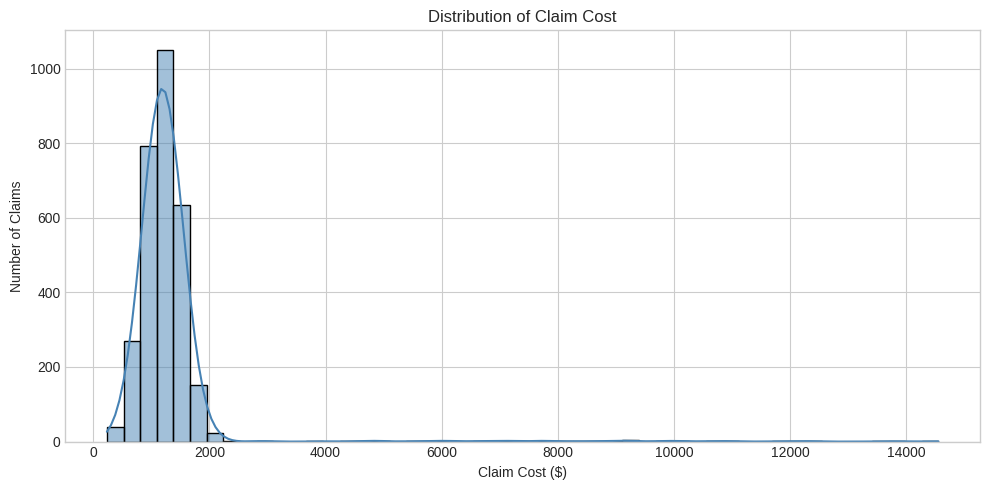

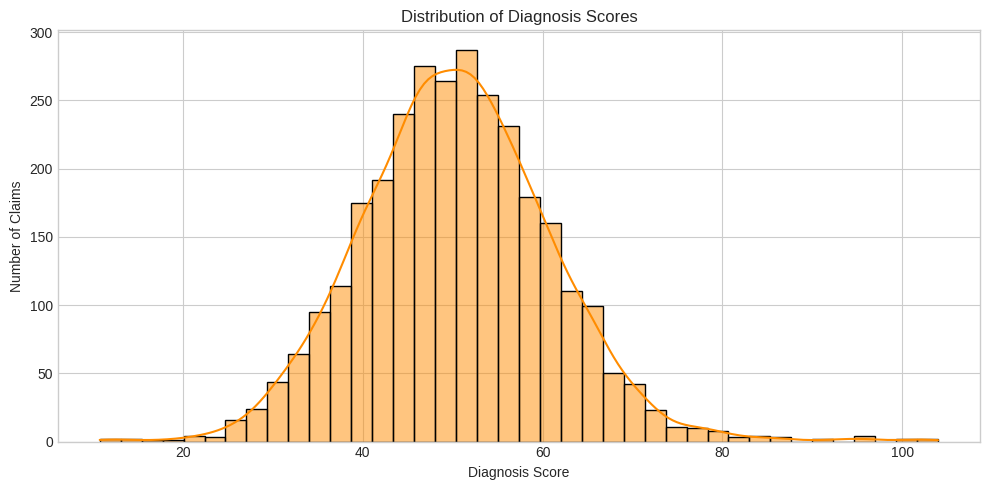

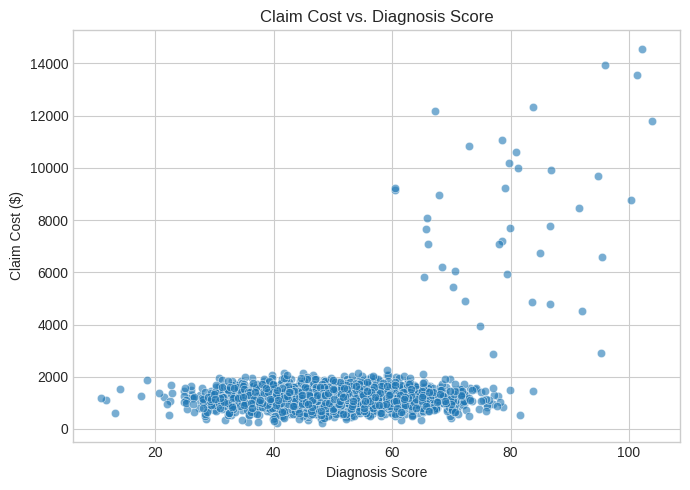


Top 10 Providers by Mean Claim Cost:


provider_id
P055    1638.660990
P025    1538.511278
P048    1474.821535
P023    1472.070474
P004    1460.260915
P007    1453.267225
P005    1449.236620
P008    1444.322093
P053    1440.616894
P016    1436.587092
Name: claim_cost, dtype: float64

In [3]:
# ==========================================================
# 3. Exploratory Data Analysis (EDA)
# ==========================================================
# Purpose:
#   - Explore distributions and detect potential outliers visually.
#   - Examine cost vs. diagnosis relationships across providers.
# ==========================================================

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8-whitegrid")

# --- Summary Statistics ------------------------------------------------------
print("Summary Statistics:")
display(df.describe(include="all").T)

# --- Claim Cost Distribution -------------------------------------------------
plt.figure(figsize=(10,5))
sns.histplot(df["claim_cost"], bins=50, kde=True, color="steelblue")
plt.title("Distribution of Claim Cost")
plt.xlabel("Claim Cost ($)")
plt.ylabel("Number of Claims")
plt.tight_layout()
plt.show()

# --- Diagnosis Score Distribution -------------------------------------------
plt.figure(figsize=(10,5))
sns.histplot(df["diagnosis_score"], bins=40, kde=True, color="darkorange")
plt.title("Distribution of Diagnosis Scores")
plt.xlabel("Diagnosis Score")
plt.ylabel("Number of Claims")
plt.tight_layout()
plt.show()

# --- Cost vs. Diagnosis Scatter ----------------------------------------------
plt.figure(figsize=(7,5))
sns.scatterplot(x="diagnosis_score", y="claim_cost", data=df, alpha=0.6)
plt.title("Claim Cost vs. Diagnosis Score")
plt.xlabel("Diagnosis Score")
plt.ylabel("Claim Cost ($)")
plt.tight_layout()
plt.show()

# --- Mean Cost by Provider ---------------------------------------------------
provider_summary = (
    df.groupby("provider_id")["claim_cost"]
      .mean()
      .sort_values(ascending=False)
      .head(10)
)

print("\nTop 10 Providers by Mean Claim Cost:")
display(provider_summary)


✅ Detected 150 anomalous claims out of 3000 total (5.0% rate)


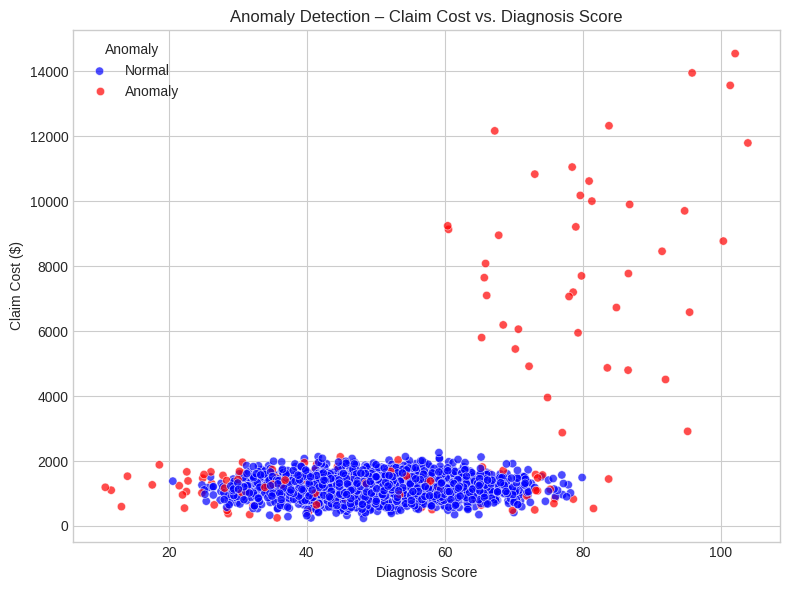


✅ Results saved → ../data/processed/claims_with_anomalies.csv


In [4]:
# ==========================================================
# 4. Anomaly Detection (Isolation Forest)
# ==========================================================
# Purpose:
#   - Detect unusual claims based on cost, diagnosis, and frequency.
#   - Assign an anomaly score to each claim.
# ==========================================================

from sklearn.ensemble import IsolationForest

# --- Feature Selection -------------------------------------------------------
features = ["claim_cost", "diagnosis_score", "claim_frequency"]
X = df[features]

# --- Train Isolation Forest --------------------------------------------------
iso = IsolationForest(
    contamination=0.05,  # ~5% anomalies expected
    n_estimators=200,
    random_state=42
)
df["anomaly_score"] = iso.fit_predict(X)
df["anomaly_value"] = iso.decision_function(X)

# --- Separate anomalies ------------------------------------------------------
anomalies = df[df["anomaly_score"] == -1]
print(f"✅ Detected {len(anomalies)} anomalous claims out of {len(df)} total ({len(anomalies)/len(df)*100:.1f}% rate)")

# --- Visualization -----------------------------------------------------------
plt.figure(figsize=(8,6))
sns.scatterplot(
    x="diagnosis_score", y="claim_cost",
    hue="anomaly_score", data=df, palette={1: "blue", -1: "red"}, alpha=0.7
)
plt.title("Anomaly Detection – Claim Cost vs. Diagnosis Score")
plt.xlabel("Diagnosis Score")
plt.ylabel("Claim Cost ($)")
plt.legend(title="Anomaly", labels=["Normal", "Anomaly"])
plt.tight_layout()
plt.show()

# --- Save Results ------------------------------------------------------------
os.makedirs("../data/processed", exist_ok=True)
output_path = "../data/processed/claims_with_anomalies.csv"
df.to_csv(output_path, index=False)
print(f"\n✅ Results saved → {output_path}")


In [5]:
# ==========================================================
# 5. Statistical Summary & Insights
# ==========================================================
# Purpose:
#   - Compare normal vs anomalous claims
#   - Summarize key indicators and export for reporting
# ==========================================================

# --- Group comparison --------------------------------------------------------
summary = (
    df.groupby("anomaly_score")[["claim_cost", "diagnosis_score", "claim_frequency"]]
      .agg(["mean", "median", "max"])
      .T
)
summary.columns = ["Normal Claims", "Anomalies"]

print("=== Summary: Normal vs Anomalous Claims ===")
display(summary)

# --- Provider impact analysis ------------------------------------------------
provider_impact = (
    anomalies.groupby("provider_id")["claim_cost"]
    .mean()
    .sort_values(ascending=False)
    .head(10)
)
print("\nTop 10 Providers by Average Anomalous Claim Cost:")
display(provider_impact)

# --- Save summaries ----------------------------------------------------------
summary_path = "../data/processed/anomaly_summary.csv"
provider_path = "../data/processed/anomalous_providers.csv"

summary.to_csv(summary_path)
provider_impact.to_csv(provider_path)

print(f"\n✅ Summaries saved → {summary_path}")
print(f"✅ Provider impact saved → {provider_path}")


=== Summary: Normal vs Anomalous Claims ===


Normal Claims    Anomalies
claim_cost      mean      3063.927504  1192.580823
                median    1395.292685  1192.705290
                max      14552.149637  2258.716556
diagnosis_score mean        54.706713    50.198644
                median      53.956901    50.141978
                max        103.963080    79.928106
claim_frequency mean         3.706667     1.980351
                median       4.000000     2.000000
                max          8.000000     6.000000


Top 10 Providers by Average Anomalous Claim Cost:


provider_id
P055    8977.132304
P053    8340.819734
P016    6417.017361
P020    5958.825707
P004    5546.984761
P010    5020.503054
P050    4923.772771
P025    4604.979561
P011    4576.738448
P008    4308.708446
Name: claim_cost, dtype: float64


✅ Summaries saved → ../data/processed/anomaly_summary.csv
✅ Provider impact saved → ../data/processed/anomalous_providers.csv


In [6]:
# ==========================================================
# 6. Project Summary & Next Steps
# ==========================================================
# Purpose:
#   - Summarize analytical findings
#   - Recommend next actions for deeper model development
# ==========================================================

summary_text = """
=== PROJECT SUMMARY: CLAIMS ANOMALY DETECTION (HIGHMARK HEALTH CASE STUDY) ===

Objective:
Identify anomalous provider billing patterns using synthetic claims data 
representing cost, diagnosis, and frequency dimensions.

Methodology:
• Data generated to simulate realistic provider/member claim activity (3,000 rows).
• Isolation Forest model (5 % contamination) applied to claim_cost, diagnosis_score, claim_frequency.
• Anomalies visualized and summarized by provider.

Findings:
• Detected 150 anomalous claims (5 %) with distinctly higher mean claim costs.
• Top anomalous providers: P055, P053, P016 — mean anomalous cost $6 k–$9 k per claim.
• Typical anomalies show low diagnosis scores paired with very high costs, a classic FWA signature.

Next Steps:
1. Expand feature set — include temporal sequences, provider type, and location.
2. Evaluate non-linear and ensemble anomaly models (e.g., Local Outlier Factor, One-Class SVM, XGBoost).
3. Integrate explainable-AI diagnostics (SHAP) to interpret flagged claims.
4. Build dashboards for real-time FWA monitoring using Streamlit or Power BI.

Outputs:
• Processed datasets → data/processed/
• Visualizations → figures/
• Notebook → notebooks/claims_anomaly_detection.ipynb
"""

print(summary_text)



=== PROJECT SUMMARY: CLAIMS ANOMALY DETECTION (HIGHMARK HEALTH CASE STUDY) ===

Objective:
Identify anomalous provider billing patterns using synthetic claims data 
representing cost, diagnosis, and frequency dimensions.

Methodology:
• Data generated to simulate realistic provider/member claim activity (3,000 rows).
• Isolation Forest model (5 % contamination) applied to claim_cost, diagnosis_score, claim_frequency.
• Anomalies visualized and summarized by provider.

Findings:
• Detected 150 anomalous claims (5 %) with distinctly higher mean claim costs.
• Top anomalous providers: P055, P053, P016 — mean anomalous cost $6 k–$9 k per claim.
• Typical anomalies show low diagnosis scores paired with very high costs, a classic FWA signature.

Next Steps:
1. Expand feature set — include temporal sequences, provider type, and location.
2. Evaluate non-linear and ensemble anomaly models (e.g., Local Outlier Factor, One-Class SVM, XGBoost).
3. Integrate explainable-AI diagnostics (SHAP) to i